# code for figure 2A-B

## relationship between simulated and inferred patristic distances for a single set of parameters. 
* Scatter plot: simulated vs. inferred patristic distances (vs. null permuted tip labels)
* Density curve: Per-bin R2 values (vs. null permuted bins) 

### import modules

In [1]:
import os

In [2]:
from tqdm.notebook import tqdm

In [3]:
import time
for i in tqdm(range(100)):
    time.sleep(0.05) # Simulate some work

  0%|          | 0/100 [00:00<?, ?it/s]

In [4]:
import tsinfer
import tskit
import msprime
import tsdate

import numpy as np
import pandas as pd

import datetime as dt
import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib.colors import TwoSlopeNorm

from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 

import itertools
from itertools import combinations

from Bio import SeqIO, AlignIO

import gzip
import csv

import subprocess, gzip, tempfile
import shutil

from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

### define proxy

In [5]:
import logging
logger = logging.getLogger("tsinfer")

def insert_proxy_samples(
        self,
        variant_data,
        *,
        sample_ids=None,
        epsilon=None,
        keep_ancestor_times=None,
        allow_mutation=None,  # deprecated alias
        **kwargs,
):
        """
        Take a set of samples from a :class:`.VariantData` instance and create additional
        "proxy sample ancestors" from them, returning a new :class:`.AncestorData`
        instance including both the current ancestors and the additional ancestors
        at the appropriate time points.

        A *proxy sample ancestor* is an ancestor based upon a known sample. At
        sites used in the full inference process, the haplotype of this ancestor
        is identical to that of the sample on which it is based. The time of the
        ancestor is taken to be a fraction ``epsilon`` older than the sample on
        which it is based.

        A common use of this function is to provide ancestral nodes for anchoring
        historical samples at the correct time when matching them into a tree
        sequence during the :func:`tsinfer.match_samples` stage of inference.
        For this reason, by default, the samples chosen from ``sample_data``
        are those associated with historical (i.e. non-contemporary)
        :ref:`individuals <sec_inference_data_model_individual>`. This can be
        altered by using the ``sample_ids`` parameter.

        .. note::

            The proxy sample ancestors inserted here will correspond to extra nodes
            in the inferred tree sequence. At sites which are not used in the full
            inference process (e.g. sites unique to a single historical sample),
            these proxy sample ancestor nodes may have a different genotype from
            their corresponding sample.

        :param VariantData variant_data: The `VariantData` instance
            from which to select the samples used to create extra ancestors.
        :param list(int) sample_ids: A list of sample ids in the ``variant_data``
            instance that will be selected to create the extra ancestors. If
            ``None`` (default) select all the historical samples, i.e. those
            associated with an :ref:`sec_inference_data_model_individual` whose
            time is greater than zero. The order of ids is ignored, as are
            duplicate ids.
        :param list(float) epsilon: An list of small time increments
            determining how much older each proxy sample ancestor is than the
            corresponding sample listed in ``sample_ids``. A single value is also
            allowed, in which case it is used as the time increment for all selected
            proxy sample ancestors. If None (default) find :math:`{\\delta}t`, the
            smallest time difference between the sample times and the next
            oldest ancestor in the current :class:`.AncestorData` instance, setting
            ``epsilon`` = :math:`{\\delta}t / 100` (or, if all selected samples
            are at least as old as the oldest ancestor, take :math:`{\\delta}t`
            to be the smallest non-zero time difference between existing ancestors).
        :param bool keep_ancestor_times: If ``False`` (the default), the existing
            times of the ancestors in the current :class:`.AncestorData` instance
            may be increased so that derived states in the inserted proxy samples.
            can have an ancestor with a mutation to that site above them (i.e. the
            infinite sites assumption is maintained). This is useful when sites
            times have been approximated by using their frequency. Alternatively,
            if ``keep_ancestor_times`` is ``True``, existing ancestor times are
            preserved, and inserted proxy sample ancestors are allowed to
            possess derived alleles at sites where there are no pre-existing
            mutations in older ancestors. This can lead to a de-novo mutation at a
            site that also has a mutation elsewhere (i.e. breaking the infinite sites
            assumption).
        :param bool allow_mutation: Deprecated alias for `keep_ancestor_times`.
        :param \\**kwargs: Further arguments passed to the constructor when creating
            the new :class:`AncestorData` instance which will be returned.

        :return: A new :class:`.AncestorData` object.
        :rtype: AncestorData
        """
        if allow_mutation is not None:
            if keep_ancestor_times is not None:
                raise ValueError(
                    "Cannot specify both `allow_mutation` and `keep_ancestor_times`"
                )
            keep_ancestor_times = allow_mutation
        self._check_finalised()
        variant_data._check_finalised()
        if self.sequence_length != variant_data.sequence_length:
            raise ValueError("variant_data does not have the correct sequence length")
        used_sites = np.isin(variant_data.sites_position[:], self.sites_position[:])
        if np.sum(used_sites) != self.num_sites:
            raise ValueError("Genome positions in ancestors missing from variant_data")

        if sample_ids is None:
            sample_ids = []
            for i in variant_data.individuals():
                if i.time > 0:
                    sample_ids += i.samples
        # sort by ID and make unique for quick haplotype access
        sample_ids, unique_indices = np.unique(np.array(sample_ids), return_index=True)

        sample_times = np.zeros(len(sample_ids), dtype=self.ancestors_time.dtype)
        for i, s in enumerate(sample_ids):
            sample = variant_data.sample(s)
            if sample.individual != tskit.NULL:
                sample_times[i] = variant_data.individual(sample.individual).time

        if epsilon is not None:
            epsilons = np.atleast_1d(epsilon)
            if len(epsilons) == 1:
                # all get the same epsilon
                epsilons = np.repeat(epsilons, len(sample_ids))
            else:
                if len(epsilons) != len(unique_indices):
                    raise ValueError(
                        "The number of epsilon values must equal the number of "
                        f"sample_ids ({len(sample_ids)})"
                    )
                epsilons = epsilons[unique_indices]

        else:
            anc_times = self.ancestors_time[:][::-1]  # find ascending time order
            older_index = np.searchsorted(anc_times, sample_times, side="right")
            # Don't include times older than the oldest ancestor
            allowed = older_index < self.num_ancestors
            if np.sum(allowed) > 0:
                delta_t = anc_times[older_index[allowed]] - sample_times[allowed]
            else:
                # All samples have times equal to or older than the oldest curr ancestor
                time_diffs = np.diff(anc_times)
                delta_t = np.min(time_diffs[time_diffs > 0])
            epsilons = np.repeat(np.min(delta_t) / 100.0, len(sample_ids))

        proxy_times = sample_times + epsilons
        time_sorted_indexes = np.argsort(proxy_times)
        reverse_time_sorted_indexes = time_sorted_indexes[::-1]
        # In cases where we have more than a handful of samples to use as proxies, it is
        # inefficient to access the haplotypes out of order, so we iterate and cache
        # (caution: the haplotypes list may be quite large in this case)
        haplotypes = [
            h[1] for h in variant_data.haplotypes(
                samples=sample_ids, sites=used_sites, recode_ancestral=True
            )
        ]

        new_anc_times = self.ancestors_time[:]  # this is a copy
        if not keep_ancestor_times:
            assert np.all(np.diff(self.ancestors_time) <= 0)
            # Find the youngest (max) ancestor ID constrained by each sample haplotype
            site_ancestor = -np.ones(self.num_sites, dtype=int)
            anc_min_time = np.zeros(self.num_ancestors, dtype=self.ancestors_time.dtype)
            # If (unusually) there are multiple ancestors for the same focal site, we
            # can take the youngest
            for ancestor_id, focal_sites in enumerate(self.ancestors_focal_sites):
                site_ancestor[focal_sites] = ancestor_id
            for hap_id in time_sorted_indexes:
                derived_sites = haplotypes[hap_id] > 0
                if np.sum(derived_sites) == 0:
                    root = 0  # no derived sites, so only needs to be below the root
                    for i, focal_sites in enumerate(self.ancestors_focal_sites):
                        if len(focal_sites) > 0:
                            if i > 0:
                                root = i - 1
                            anc_min_time[root] = proxy_times[hap_id] + epsilons[hap_id]
                            break
                else:
                    max_anc_id = np.max(site_ancestor[derived_sites])  # youngest ancstr
                    if max_anc_id >= 0:
                        anc_min_time[max_anc_id] = proxy_times[hap_id] + epsilons[hap_id]
            # Go from youngest to oldest, pushing up the times of the ancestors to
            # achieve compatibility with infinite sites.
            # TODO - replace with something mre efficient that uses time_diffs
            for anc_id in range(self.num_ancestors - 1, -1, -1):
                current_time = new_anc_times[anc_id]
                if anc_min_time[anc_id] > current_time:
                    new_anc_times[:(anc_id + 1)] += anc_min_time[anc_id] - current_time
            assert new_anc_times[1] > np.max(sample_times)  # root ancestor

        with self.__class__(  # Create new AncestorData instance to return
            variant_data.sites_position[:][used_sites],
            variant_data.sequence_length,
            **kwargs,
        ) as other:
            mutated_sites = set()  # To check if mutations have occurred yet
            ancestors_iter = self.ancestors()
            anc = next(ancestors_iter, None)
            for i in reverse_time_sorted_indexes:
                proxy_time = proxy_times[i]
                sample_id = sample_ids[i]
                haplotype = haplotypes[i]
                derived_sites = set(np.where(haplotype > 0)[0])
                while anc is not None and new_anc_times[anc.id] > proxy_time:
                    anc_time = new_anc_times[anc.id]
                    other.add_ancestor(
                        anc.start, anc.end, anc_time, anc.focal_sites, anc.haplotype)
                    mutated_sites.update(anc.focal_sites)
                    anc = next(ancestors_iter, None)
                if not derived_sites.issubset(mutated_sites):
                    assert not keep_ancestor_times
                    logging.info(
                        f"Infinite sites assumption deliberately broken: {sample_id}"
                        "contains an allele which requires a novel mutation."
                    )
                logger.debug(
                    f"Inserting proxy ancestor: sample {sample_id} at time {proxy_time}"
                )
                other.add_ancestor(
                    start=0,
                    end=self.num_sites,
                    time=proxy_time,
                    focal_sites=[],
                    haplotype=haplotype,
                )
            # Add any ancestors remaining in the current instance
            while anc is not None:
                anc_time = new_anc_times[anc.id]
                other.add_ancestor(
                    anc.start, anc.end, anc_time, anc.focal_sites, anc.haplotype,  
                )
                anc = next(ancestors_iter, None)

            other.clear_provenances()
            for timestamp, record in self.provenances():
                other.add_provenance(timestamp, record)
            other.record_provenance(command="insert_proxy_samples", **kwargs)

        assert other.num_ancestors == self.num_ancestors + len(sample_ids)
        return other

In [6]:
tsinfer.AncestorData.insert_proxy_samples = insert_proxy_samples

In [7]:
def run_proxy(vdata, mu, rr_value=None, mm_value=None):
    if rr_value is not None:
        rr = rr_value 
        mm = mm_value
    else: 
        rr = None
        mm = None

    anc = tsinfer.generate_ancestors(vdata)
    anc_proxy = anc.insert_proxy_samples(vdata)
    anc_proxy_ts = tsinfer.match_ancestors(vdata, anc_proxy, recombination_rate=rr, mismatch_ratio=mm)
    ts_proxy = tsinfer.match_samples(vdata, anc_proxy_ts, force_sample_times=True, recombination_rate=rr)
    simplified_proxy = tsdate.preprocess_ts(ts_proxy, erase_flanks=False)

    dated_proxy = tsdate.date(
        simplified_proxy,
        mutation_rate=mu,
        time_units="generations",
        match_segregating_sites=True,
        rescaling_intervals=1,
    )
    return rr, mm, dated_proxy
     

### core functions

#### binning

In [8]:
def make_edges(L, bin_size):
    return np.arange(0, int(L) + bin_size, bin_size, dtype=np.int64)

def add_bins(df, positions):
    out = []
    
    for i, pos in enumerate(positions):
        mask = (df["left"] <= pos) & (pos < df["right"])   # half-open [left, right) like tskit intervals
        if mask.any():
            tmp = df.loc[mask].copy()
            tmp["bin"] = i
            tmp["position"] = int(pos)
            out.append(tmp)
            
    return pd.concat(out, ignore_index=True)

def align_mrcas(sim_df, inf_df, positions):
    sim_b = add_bins(sim_df, positions)
    inf_b = add_bins(inf_df, positions)
    
    merged = pd.merge(
        inf_b, sim_b,
        on=["sample_a", "sample_b", "bin"],
        suffixes=("_inf", "_sim")
    )
    
    return merged

#### random permutations of bin order

In [9]:
def random_permutations(n_bins, n_reps, seed):
    rng = np.random.default_rng(seed)
    I = np.arange(n_bins, dtype=np.int32)
    out = []
    
    while len(out) < n_reps:
        p = rng.permutation(n_bins).astype(np.int32)
        if np.any(p != I):        # allow some fixed points; switch to np.all for strict i.e. no bins unchanged
            out.append(p)
            
    return out

def apply_bin_perm(merged_base, perm):
    df = merged_base.copy()
    key = df[["sample_a","sample_b","bin","mrca_inf"]].rename(
        columns={"bin":"src_bin","mrca_inf":"mrca_inf_src"}
    )
    
    mapper = {i:int(j) for i,j in enumerate(perm)}
    df = df.assign(src_bin=df["bin"].map(mapper))
    df = df.merge(key, on=["sample_a","sample_b","src_bin"], how="left", validate="many_to_one")
    df["mrca_inf"] = df["mrca_inf_src"].to_numpy()
    
    return df.drop(columns=["mrca_inf_src","src_bin"])

scoring

In [10]:
def r2_log1p(x, y):
    x = np.log1p(x)
    y = np.log1p(y)
    r = np.corrcoef(x, y)[0, 1]

    return r**2


def r2_by_bin(merged):
    return (
        merged
        .groupby("bin", sort=False)
        .apply(lambda group: r2_log1p(group["mrca_inf"], group["mrca_sim"]))
        .dropna()
    )

#### simulation/inference

In [11]:
gen_time_days = 1.0 
gen_per_year = 365.0 

def years_to_gen(years): 
    return years*gen_per_year

In [12]:
def sim(ne, L, rr, mu, seed): 

    ts = msprime.sim_ancestry(
        samples = [
            msprime.SampleSet(20, time=0, ploidy = 1), 
            msprime.SampleSet(15, time=years_to_gen(5), ploidy = 1), 
            msprime.SampleSet(15, time=years_to_gen(10), ploidy = 1), 
            msprime.SampleSet(10, time=years_to_gen(25), ploidy = 1), 
            msprime.SampleSet(5, time=years_to_gen(50), ploidy = 1)
        ],
        sequence_length=L,
        recombination_rate=rr,    
        population_size=ne,
        random_seed=seed,
    )
    
    ts = msprime.sim_mutations(ts, rate=mu, random_seed = seed)

    dated_ts = tsdate.date(ts, 
                       mutation_rate=mu, # same mutation rate used for simulation 
                       time_units="generations", # dont want to switch this or nodes and samples will have different units
                       match_segregating_sites = True,
                       rescaling_intervals = 1
                       )
    
    samples = list(dated_ts.samples()) ######## return 

    # get ancestral states
    ancestral_states = []
    
    for site in ts.sites():
        if site.ancestral_state is None:
            ancestral_states.append("N")
            #print("N")
        else:
            ancestral_states.append(str(site.ancestral_state))
            #print(site.ancestral_state)
    
    ancestral_states = np.array(ancestral_states) ######### return

    return dated_ts, samples, ancestral_states  

In [13]:
def get_sims_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(0, dated_ts.get_num_trees()):
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            num_trees = dated_ts.num_trees
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r, "num_trees_sim": num_trees})
            
    mrcas = pd.DataFrame(res) 
    return mrcas


def get_res_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(1, dated_ts.get_num_trees()-1): #flanking trees are not informative and must be trimmed
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            num_trees = dated_ts.num_trees
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r, "num_trees": num_trees})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

In [14]:
# get dated ts, export VCZ
def simulate_one(mu, rr, seed, prefix="sim"):
    dated_ts, samples, ancestral_states = sim(ne, L, rr, mu, seed = seed)  # ground truth TS
    vcz_path = export_sim(prefix, dated_ts, mu, rr, seed, workdir="vcf_stage")
    
    return dated_ts, samples, ancestral_states, vcz_path

# use simulated ts to make mrca table
def mrca_table_sim(ts_sim):
    sim_df = get_sims_times(ts_sim, list(ts_sim.samples()))
    return sim_df.rename(columns={"mrca": "mrca_sim"})

# re-import genotypes, run inference, compute inferred MRCA
def infer_one(vcz_path, ancestral_states, individuals_time, mu, rr, seed, mm=1):
    vdata = import_sim(vcz_path, ancestral_states, individuals_time)
    rr_used, mm_used, dated_proxy = run_proxy(vdata, mu, rr_value=rr, mm_value=mm)
    inf_df = get_res_times(dated_proxy, list(dated_proxy.samples()))
    return inf_df.rename(columns={"mrca": "mrca_inf"})


import/export

In [15]:
def fmt_sci(x):
    s = f"{x:.3e}"
    s = s.replace("+0", "+").replace("-0", "-") # reformatting numbers
    return s

def vcz_name(prefix, mu, rr, seed):
    return f"{prefix}_mu{fmt_sci(mu)}_rr{fmt_sci(rr)}_seed{seed}.vcf.gz.icf.vcz"

# export
def export_sim(prefix, ts, mu, rr, seed, workdir=".", force=False):
    os.makedirs(workdir, exist_ok=True)

    base = os.path.join(workdir, vcz_name(prefix, mu, rr, seed))             # ...vcf.gz.icf.vcz
    vcf_path   = base.replace(".vcf.gz.icf.vcz", ".vcf")
    vcfgz_path = base.replace(".icf.vcz", "")                                  # ...vcf.gz
    icf_path   = base.replace(".vcz", "")                                      # ...vcf.gz.icf

    # if .vcz exists, skip all
    if os.path.exists(base):
        return os.path.abspath(base)

    # if .icf exists, encode .vcz
    if os.path.exists(icf_path):
        cmd = ["vcf2zarr", "encode", icf_path, base]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)
        return os.path.abspath(base)

    # 2) if .vcf.gz, explode -> .icf and encode -> .vcz
    if os.path.exists(vcfgz_path):
        cmd = ["vcf2zarr", "explode", vcfgz_path, icf_path]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)
        cmd = ["vcf2zarr", "encode", icf_path, base]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)
        return os.path.abspath(base)

    # create .vcf, compress 
    if not os.path.exists(vcfgz_path):
        with tempfile.NamedTemporaryFile("w", delete=False, dir=workdir) as tmp:
            tmp_vcf = tmp.name
            ts.write_vcf(tmp, position_transform=lambda x: np.fmax(1, x))
        # compress
        if shutil.which("bgzip"):
            subprocess.run(["bgzip", "-f", tmp_vcf], check=True)
            # bgzip makes tmp_vcf + .gz
            os.replace(tmp_vcf + ".gz", vcfgz_path)
        else:
            with open(tmp_vcf, "rb") as fin, gzip.open(vcfgz_path, "wb") as fout:
                fout.write(fin.read())
            os.remove(tmp_vcf)

    # explode vcf.gz to icf
    if not os.path.exists(icf_path):
        cmd = ["vcf2zarr", "explode", vcfgz_path, icf_path]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)

    # encode icf to vzc
    if not os.path.exists(base):
        cmd = ["vcf2zarr", "encode", icf_path, base]
        if force: cmd.append("--force")
        subprocess.run(cmd, check=True)

    return os.path.abspath(base)


# import vcz -> variant data object
def import_sim(vcz_path, ancestral_states, individuals_time):
    import tsinfer
    vdata = tsinfer.VariantData(
        vcz_path,
        ancestral_state=np.asarray(ancestral_states),
        individuals_time=np.asarray(individuals_time),
    )
    return vdata

### read in data

In [16]:
inf_all = pd.read_csv('../out/inf_all.csv')
inf_all

,mu,pm,rr,rep,bin,r2,kind,n_trees_sim,n_trees_inf
0,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,inferred,1,3
1,1.000000e-10,0.001,1.000000e-13,0,2,0.915093,inferred,1,3
2,1.000000e-10,0.001,1.000000e-13,0,3,0.915093,inferred,1,3
3,1.000000e-10,0.001,1.000000e-13,0,4,0.915093,inferred,1,3
4,1.000000e-10,0.001,1.000000e-13,0,5,0.915093,inferred,1,3
...,...,...,...,...,...,...,...,...,...
690,1.000000e-07,3.000,3.000000e-07,0,25,0.376952,inferred,137234,9914
691,1.000000e-07,3.000,3.000000e-07,0,26,0.450914,inferred,137234,9914
692,1.000000e-07,3.000,3.000000e-07,0,27,0.388364,inferred,137234,9914
693,1.000000e-07,3.000,3.000000e-07,0,28,0.277969,inferred,137234,9914


In [17]:
null_all = pd.read_csv('../out/null_all.csv')
null_all['kind'] = 'null'
null_all

,mu,pm,rr,rep,bin,r2,kind
0,1.000000e-10,0.001,1.000000e-13,0,1,0.915093,null
1,1.000000e-10,0.001,1.000000e-13,0,2,0.915093,null
2,1.000000e-10,0.001,1.000000e-13,0,3,0.915093,null
3,1.000000e-10,0.001,1.000000e-13,0,5,0.915093,null
4,1.000000e-10,0.001,1.000000e-13,0,6,0.915093,null
...,...,...,...,...,...,...,...
6707,1.000000e-07,3.000,3.000000e-07,0,25,0.065842,null
6708,1.000000e-07,3.000,3.000000e-07,0,26,0.080502,null
6709,1.000000e-07,3.000,3.000000e-07,0,27,0.092996,null
6710,1.000000e-07,3.000,3.000000e-07,0,28,0.033299,null


### plot single examples (figure 2A, 2B) 

In [18]:
mu0 = 1.000000e-8
pm0 = 0.1
bin_size = 1e5
seed = 5
ne = 5000
L = 3e6

N_NULL = 10 # null perms per replicate

In [59]:
def run_cell(mu, pm, rep, seed):
    rr = pm * mu

    # simulate + export VCF/VCZ
    ts, samples, ancestral_states, vcz_path = simulate_one(mu, rr, seed=seed)

    # build truth table from the simulated ts
    edges = make_edges(int(ts.sequence_length), bin_size)
    sim_df = mrca_table_sim(ts)

    # per-individual times for import
    sample_nodes = np.array(list(ts.samples()), dtype=int)
    individuals_time = ts.tables.nodes.time[sample_nodes]

    # inference w/ re-imported genomic data
    inf_df = infer_one(vcz_path, ancestral_states, individuals_time, mu=mu, rr=rr, seed=seed, mm=1)

    ##sim_df and inf_df have num_trees .... extract
    n_trees_sim = int(sim_df["num_trees_sim"].iloc[0])
    n_trees_inf = int(inf_df["num_trees"].iloc[0])

    # align + R²
    merged = align_mrcas(sim_df, inf_df, edges)
    r2_inf = r2_by_bin(merged)
    r2_vals = np.asarray(r2_inf.to_numpy()).ravel()
    bins = np.asarray(r2_inf.index.to_numpy(), dtype=np.int32).ravel()
    n = len(r2_vals)

    #print(r2_vals)
    
    inf_rows = pd.DataFrame({
        "mu":   np.full(n, mu, dtype=float),
        "pm":   np.full(n, pm, dtype=float),
        "rr":   np.full(n, rr, dtype=float),
        "rep":  np.full(n, rep, dtype=int),
        "bin":  bins,
        "r2":   r2_vals,
        "kind": np.full(n, "inferred", dtype=object),
        "n_trees_sim": np.full(n, n_trees_sim, dtype=int),
        "n_trees_inf": np.full(n, n_trees_inf, dtype=int) 
    })


    # nulls: reuse merged; permute bins
    null_rows = []
    if N_NULL > 0:
        perms = random_permutations(n_bins=len(edges)-1, n_reps=N_NULL, seed=seed)
        for p in perms:
            m_perm = apply_bin_perm(merged, p)
            r2_null = r2_by_bin(m_perm)
            if len(r2_null):
                null_rows.append(pd.DataFrame({
                    "mu": mu, 
                    "pm": pm, 
                    "rr": rr, 
                    "rep": rep,
                    "bin": r2_null.index.astype(np.int32),
                    "r2": r2_null.values,
                    "kind": "null"
                }))
    null_df = pd.concat(null_rows, ignore_index=True) if null_rows else pd.DataFrame(
        columns=["mu","pm","rr","rep","bin","r2","kind"]
    )
    
    return inf_rows, null_df

#### simulate one

In [20]:
rr0 = mu0 * pm0

# simulate once 
ts_sim, samples, ancestral_states, vcz_path = simulate_one(mu0, rr0, seed)

# MRCA table from simulated tree sequence
edges = make_edges(int(ts_sim.sequence_length), bin_size)
sim_df = mrca_table_sim(ts_sim)  

# inference using simulation parameters 
sample_nodes = np.array(list(ts_sim.samples()), dtype=int)
individuals_time = ts_sim.tables.nodes.time[sample_nodes]

inf_df = infer_one(
    vcz_path,
    ancestral_states,
    individuals_time,
    mu=mu0,
    rr=rr0,
    seed=seed,
    mm=1,    
) 

# align MRCA tables and build patristic distances
merged = align_mrcas(sim_df, inf_df, edges)
pat_true = merged["mrca_sim"].to_numpy()
pat_inf  = merged["mrca_inf"].to_numpy()

# remove NAs
mask = np.isfinite(pat_true) & np.isfinite(pat_inf)
pat_true = pat_true[mask]
pat_inf  = pat_inf[mask]

In [21]:
merged

,index_inf,sample_a,sample_b,mrca_inf,width_inf,left_inf,right_inf,num_trees,bin,position_inf,index_sim,mrca_sim,width_sim,left_sim,right_sim,num_trees_sim,position_sim
0,6,0,1,2946.930266,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
1,6,0,2,6230.801813,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
2,6,0,3,6230.801813,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
3,6,0,4,6230.801813,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
4,6,0,5,2946.930266,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60315,219,61,63,18447.602111,27596.0,2896723.0,2924319.0,222,29,2900000,430,19713.711703,12925.0,2888916.0,2901841.0,441,2900000
60316,219,61,64,32926.568192,27596.0,2896723.0,2924319.0,222,29,2900000,430,31719.630646,12925.0,2888916.0,2901841.0,441,2900000
60317,219,62,63,32926.568192,27596.0,2896723.0,2924319.0,222,29,2900000,430,31719.630646,12925.0,2888916.0,2901841.0,441,2900000
60318,219,62,64,25097.562455,27596.0,2896723.0,2924319.0,222,29,2900000,430,24621.803193,12925.0,2888916.0,2901841.0,441,2900000


## plot

### scatter: sim vs inf patristic distances 

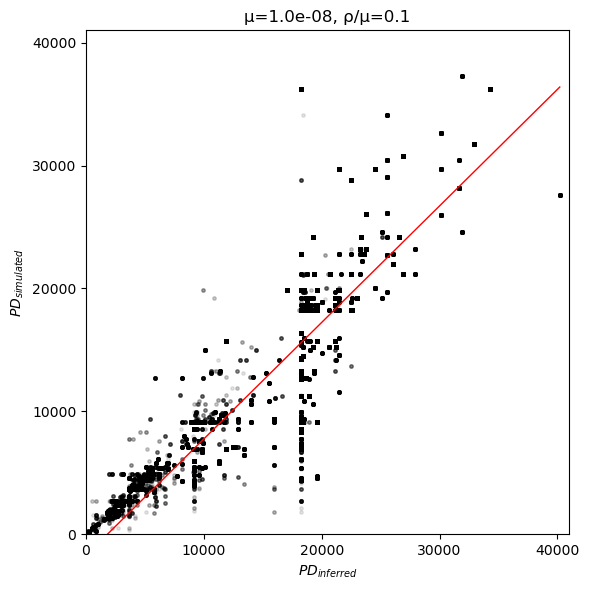

In [56]:
# plot scatter + regression lines for inf

plt.figure(figsize=(6, 6))

sc = plt.scatter(
    pat_inf, 
    pat_true,
    s=6, alpha=0.1, 
    c = 'black'
)

m, b = np.polyfit(pat_inf, pat_true, 1)
x_regression = np.linspace(pat_inf.min(), pat_inf.max(), 200).reshape(-1, 1)
y_regression = m * x_regression + b
plt.plot(x_regression, y_regression, color='red', linestyle='-', lw = 1)

plt.xticks([0, 10000, 20000, 30000, 40000]) 
plt.yticks([0, 10000, 20000, 30000, 40000])

plt.xlim(0,41000)
plt.ylim(0,41000)

plt.ylabel(r"$PD_{simulated}$")
plt.xlabel(r"$PD_{inferred}$")

plt.title(f"μ={mu0:.1e}, ρ/μ={pm0}")

plt.tight_layout()

#plt.savefig("example_scatter.png")
plt.show()

### scatter: sim vs null patristic distances

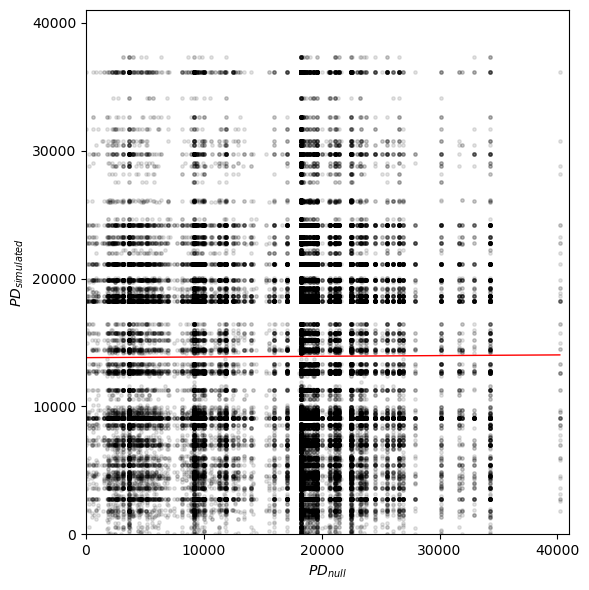

In [57]:
# random permutation of tip labels 

rng = np.random.default_rng(seed + 12345)
pat_null = pat_inf.copy()
rng.shuffle(pat_null)

# plot scatter + regression lines for null

plt.figure(figsize=(6, 6))

sc = plt.scatter(
    pat_null, 
    pat_true,
    s=6, alpha=0.1, 
    c = 'black'
)

m, b = np.polyfit(pat_null, pat_true, 1)
x_null_regression = np.linspace(pat_null.min(), pat_null.max(), 200).reshape(-1, 1)
y_regression = m * x_null_regression + b
plt.plot(x_null_regression, y_regression, color='red', linestyle='-', lw = 1)

plt.xlabel("null patristic distance (generations)")
plt.ylabel("simulated patristic distance (generations)")

plt.xticks([0, 10000, 20000, 30000, 40000]) 
plt.yticks([0, 10000, 20000, 30000, 40000])

plt.xlim(0,41000)
plt.ylim(0,41000)

plt.ylabel(r"$PD_{simulated}$")
plt.xlabel(r"$PD_{null}$")


#plt.title(f"μ={mu0:.1e}, ρ/μ={pm0}")

plt.tight_layout()

#plt.savefig("example_scatter_null.png")
plt.show()


seems kinda messy ... limit to one tree? (65 tips = 2080 combinations...)

In [87]:
merged

,index_inf,sample_a,sample_b,mrca_inf,width_inf,left_inf,right_inf,num_trees,bin,position_inf,index_sim,mrca_sim,width_sim,left_sim,right_sim,num_trees_sim,position_sim
0,6,0,1,2946.930266,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
1,6,0,2,6230.801813,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
2,6,0,3,6230.801813,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
3,6,0,4,6230.801813,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
4,6,0,5,2946.930266,35794.0,73645.0,109439.0,222,1,100000,9,4907.251272,7471.0,99448.0,106919.0,441,100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60315,219,61,63,18447.602111,27596.0,2896723.0,2924319.0,222,29,2900000,430,19713.711703,12925.0,2888916.0,2901841.0,441,2900000
60316,219,61,64,32926.568192,27596.0,2896723.0,2924319.0,222,29,2900000,430,31719.630646,12925.0,2888916.0,2901841.0,441,2900000
60317,219,62,63,32926.568192,27596.0,2896723.0,2924319.0,222,29,2900000,430,31719.630646,12925.0,2888916.0,2901841.0,441,2900000
60318,219,62,64,25097.562455,27596.0,2896723.0,2924319.0,222,29,2900000,430,24621.803193,12925.0,2888916.0,2901841.0,441,2900000


In [103]:
from itertools import combinations
len(list(combinations(range(0,65), 2))) * 29 # 2080 combinations * 29 bins

60320

### density curve: r2 values
i think i can just plot values from inf_all and null_all for a single pm single rep


In [60]:
inf_all, null_all = run_cell(mu0, pm0, rep = 0, seed = seed)

In [61]:
vals = np.array(inf_all['r2']) 
null = np.array(null_all['r2'])

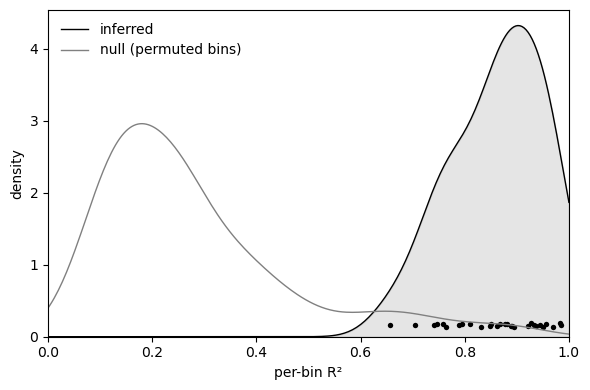

In [83]:
xmin, xmax = 0.0, 1.0

fig, ax = plt.subplots(figsize=(6, 4))

### plot inf ###

# density curve for inf
x_grid = np.linspace(xmin, xmax, 256)
kde = gaussian_kde(vals)
y = kde(x_grid)
y /= np.trapz(y, x_grid)
ax.plot(x_grid, y, lw=1, color="black", label = 'inferred')

# mean line for inf
# ax.axvline(np.mean(vals), lw=0.8, alpha=0.6, color="mediumblue")
# ax.text(
#         np.mean(vals),                                    
#         ax.get_ylim()[1] * 0.9, 
#         f"mean = {np.mean(vals):.3f}",  
#         #rotation=90,                       
#         va="top", ha="left",
#         color="mediumblue", fontsize=8
#     )

# points for inf
trans = ax.get_xaxis_transform()
y0 = 0.035
bb = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
dy = 2/(bb.height * ax.figure.dpi)
ys = np.full(vals.shape, y0) + (np.random.rand(vals.size)-0.5)*2*dy
ax.scatter(vals, ys, s=15, alpha=1, transform=trans, lw=0, color="black")

# shade area under curve 
line = ax.lines[0]
x, y = line.get_data()
ax.fill_between(x, y, y2=0, alpha=0.1, color = 'black')

### plot null ###

# density curve for null
x_grid_n = np.linspace(xmin, xmax, 256)
kde_n = gaussian_kde(null)
y_n = kde_n(x_grid_n)
y_n /= np.trapz(y_n, x_grid_n)
ax.plot(x_grid_n, y_n, "-", lw=1, color="grey", label="null (permuted bins)")

# # mean line for null
# ax.axvline(np.mean(null), lw=0.8, alpha=0.6, color="grey")

# # points for null
# trans = ax.get_xaxis_transform()
# y0 = 0.015
# bb = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
# dy = 2/(bb.height * ax.figure.dpi)
# ys = np.full(null.shape, y0) + (np.random.rand(null.size)-0.5)*2*dy
# ax.scatter(null, ys, s=1, alpha=0.7, transform=trans, lw=0, color="grey")

# axes
ax.set_xlim(xmin, xmax)
ax.set_ylim(bottom=0)
ax.set_xlabel("per-bin R²")
ax.set_ylabel("density")
#ax.set_title("R² density")
#ax.grid(True, alpha=0.25)
ax.legend(frameon = False)

plt.tight_layout()

#plt.savefig('example_density.png')

plt.show()